# COVID-19 Infection curve analysis and SEIR model simulation                                                                  
## Naoaki ONO nono@is.nasit.jp   

CoViD-19 infection curve (in Japan, from Jan. 15, 2020) analysis using R.

The numbers of infected and tested by PCR have been gathered from the website of Ministry of Health, Labour and Welfare, Japan

Sources and data are available on GitHub.
https://github.com/naono-git/covid19

Open using [nbviewer service](https://nbviewer.jupyter.org/github/naono-git/covid19/blob/master/covid19.nara.ipynb)


### Nara model

Tentative prediciton of infection in Nara prefecture based on Total and Kinki model.

In [546]:
library(date)
source("src/plotUtil.R")

First, we evaluate total Japan corona virus infection.

And assume the exponential model to evaluate the initial growth curve.

In [547]:
# covid <- read.delim("data/covid19.txt", header=TRUE, sep="\t")
covid <- read.delim("data/covid19.total.txt", header=TRUE, sep="\t")
nd <- nrow(covid)

stamp <- paste(c(covid[nd,1],sprintf("%02d",covid[nd,2]),sprintf("%02d",covid[nd,3])),collapse="")
stamp

[1] "20200407"

In [548]:
ddd <- mdy.date(month=covid$mm, day=covid$dd, year=covid$yy)
d0  <- ddd[1]
dd1 <- ddd-d0 ## relative date starting from 2020/01/15                                                   
dd1[1] <- 7   ## initial offset (aribtrary chosen) 

In [549]:
## dates to plot ticks                                                                                    
mdlabel <- rbind(c(1,15),
                 c(2, 1),
                 c(2,15),
                 c(3, 1),
                 c(3,15),
                 c(4, 1),
                 c(4,15),
                 c(5, 1),
                 c(5,15),
                 c(6, 1),
                 c(6,15),
                 c(7, 1),
                 c(7,15)
                )
ddlabel <- apply(mdlabel,1,function(xx){
    mdy.date(xx[1],xx[2],2020)
})
## label to plot ticks                                                                                    
ticklabel <- apply(mdlabel,1,paste,collapse="/")

In [550]:
logd <- log(dd1)        ## log day
logi <- log(covid$i)    ## log number of infected                                                               
logp <- log(covid$PCR)  ## log number of PCR

In [551]:
daydiff <- function(xx){
    return(xx - c(0,xx[-length(xx)]))
}
pred_pow <- function(xx,cc,ll){
    return(xx^ll*exp(cc))
}
pred_exp <- function(xx,cc,ll){
    return(cc*exp(ll*xx))
}

We compared the power model and the exponential model.

It seems difficult to evaluate quantitatively.

Maybe, log-likelihood and free energy or, WAIC would be useful.

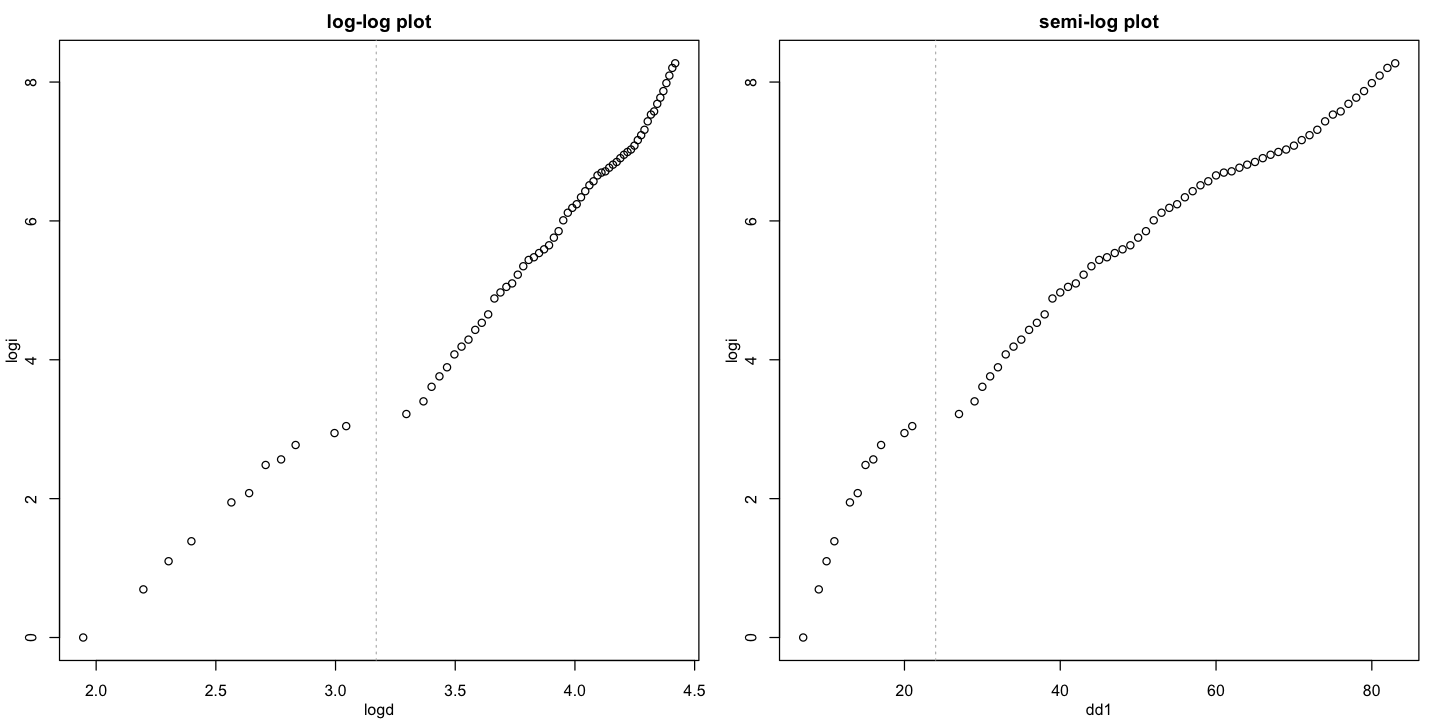

In [552]:
options(repr.plot.width=12, repr.plot.height=6)
par(mfcol=c(1,2))
par.margin("smart")

plot(logd, logi, main="log-log plot")
abline(v=mean(logd[11:12]), lty=3, col=8)
# abline(-2,2,lty=3, col=2)

plot(dd1, logi, main="semi-log plot")
abline(v=mean(dd1[11:12]), lty=3, col=8)
## ... Do you think which looks more linearly?

In [553]:
## Fitting by power. 1, fit for the earlier stage                                                   
model_pow_0 <- lm(logi~logd)
model_pow_0

model_pow_1 <- lm(logi[1:11]~logd[1:11])
model_pow_1

## Fitting by power. 2, fit for the latter stage                                                   
model_pow_2 <- lm(logi[12:nd]~logd[12:nd])
model_pow_2


Call:
lm(formula = logi ~ logd)

Coefficients:
(Intercept)         logd  
     -6.888        3.280  



Call:
lm(formula = logi[1:11] ~ logd[1:11])

Coefficients:
(Intercept)   logd[1:11]  
     -5.562        2.894  



Call:
lm(formula = logi[12:nd] ~ logd[12:nd])

Coefficients:
(Intercept)  logd[12:nd]  
    -10.917        4.279  


We also applided exponential fitting.

Since there seems a significant change in the growth at 2/11 (gray line), we focused on the latter period.

In [554]:
## We focus on the latter growth (D > Feb. 11th)
model_exp_2 <- lm(logi[12:nd]~dd1[12:nd])
model_exp_2
cc_exp_2 <- exp(model_exp_2$coefficients[1])
lambda_tmp <- model_exp_2$coefficients[2]


Call:
lm(formula = logi[12:nd] ~ dd1[12:nd])

Coefficients:
(Intercept)   dd1[12:nd]  
     1.5265       0.0819  


COVID19_infection_curve_semilog_20200407.jpg 


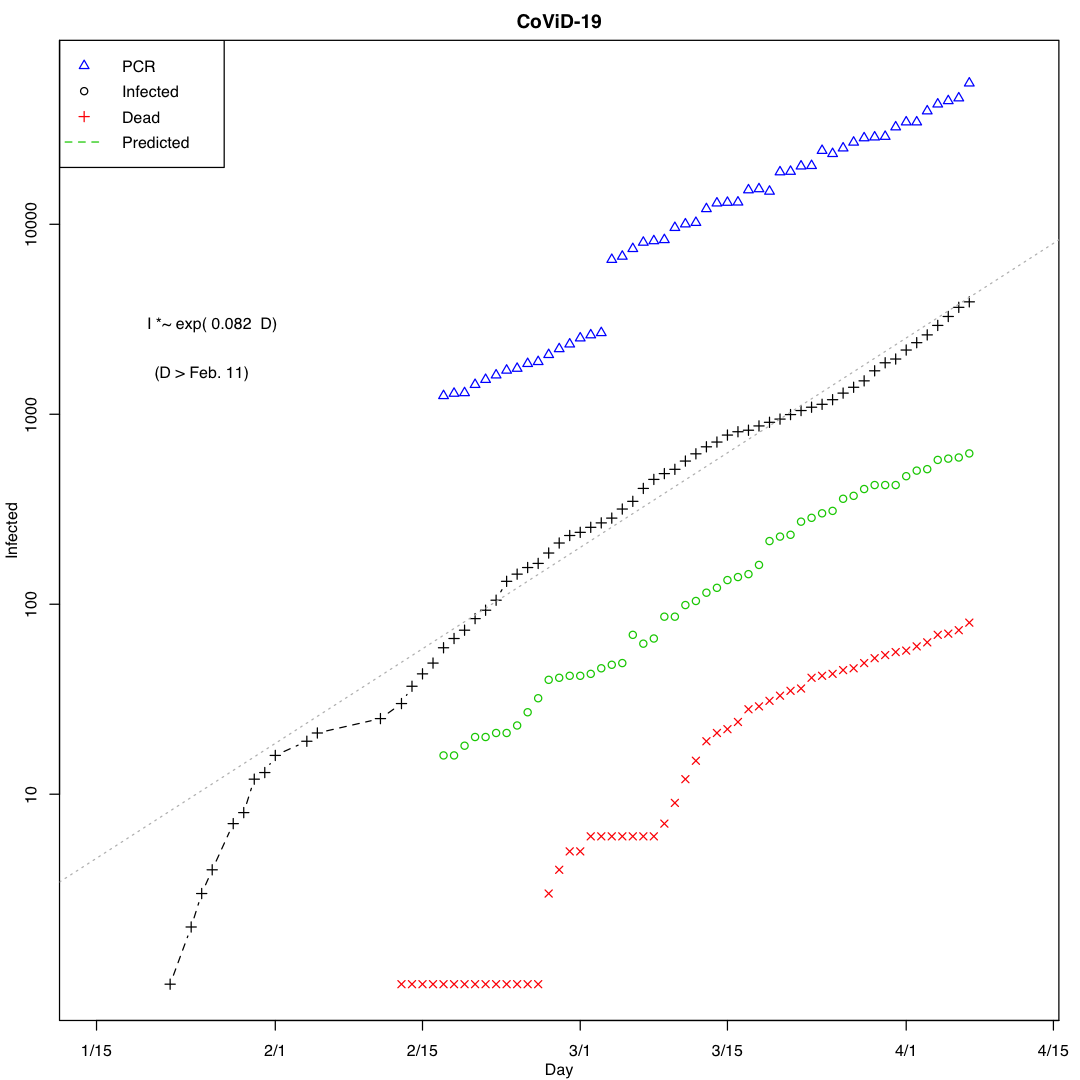

In [555]:
options(repr.plot.width=9, repr.plot.height=9)

file_plot1 <- paste("COVID19_infection_curve_semilog",stamp,sep="_")

plotFigure(function(){
    plot(dd1, logi, axes=FALSE, frame=TRUE, type="b", lty=2, pch=3,
         xlim=c(0,88),ylim=c(0,11), xlab="Day", ylab="Infected", main="CoViD-19")
    points(dd1, logp, pch=2, col=4)
    points(dd1, log(covid$d), pch=4, col=2)
    points(dd1, log(covid$re), pch=1, col=3)
    axis(1,at=ddlabel-d0,labels=ticklabel)
    axis(2,at=log(c(10^(1:5))),labels=c(10^(1:5)))

    legend("topleft",lty=c(0,0,0,2),pch=c(2,1,3,NA),col=c(4,1,2,3),legend=c("PCR","Infected","Dead","Predicted"))
    # text(10,8,TeX(paste("$I \\propto exp(",round(ll_exp_2,3)," D)$")))
    text(11,8,paste("I *~ exp(",round(lambda_tmp,3)," D)"))
    text(10,7.4,"(D > Feb. 11)")

    abline(model_exp_2, lty=3, col=8)
},rr=1.5,dir="fig",file=file_plot1,dev=c("x11","jpg"))

## Simulation

In general, the dynamics of infection is described by the "SIR" model.
$$
\frac{dS}{dt} = -\beta IS/N \\
\frac{dI}{dt} = \beta IS/N - \gamma I \\
\frac{dR}{dt} = \gamma I,
$$
where S denotes the population ratio of susceptible, I denotes infected, R denotes recoverd, respectively, and $\beta$ and $\gamma$ are the coefficient of infection and recovery.

In the [model proposed by Akihiro Sato](https://www.fttsus.jp/covinfo/pref-simulation/?fbclid=IwAR1GubBOG4Y9JhwUMKXryAS6ThLnyWnH7nTfSM-_eDS5uAyDzSjCMyuXhr0) he introduced delay befor onset and introduced a coefficient of the social distance.

In the model proposed by Shao and others [COVID-19 in Japan: What could happen in the
future?](https://www.medrxiv.org/content/10.1101/2020.02.21.20026070v1.full.pdf), they introduced $I$, infected, $J$, infected and hospitalized, $G$, infected and isolated but not diagnosed to evaluate quarantine strategies.

In this report, we do not introduce social distance nor isolation yet. But try to quantitatively evaluate unseen population of infected and not yet diagnosed population. 

In order to consider infection before onset, we assume a modified SEIR model, as follows.
$S$: susceptible, $E$: exposed and infected but not show symptoms yet, $I$: infected and separeted in a hospital, $R_E$, $R_I$: recovered from $E$ or $I$, respectively, and no longer susceptible.

$$
\frac{dS}{dt} = -\alpha E S /N \\
\frac{dE}{dt} = \alpha E S/N - \beta E - \gamma E\\
\frac{dI}{dt} = \beta E - \gamma I \\
\frac{dR_E}{dt} = \gamma E, \\
\frac{dR_I}{dt} = \gamma I,
$$
where $N$ is the population of the country (Nara), $\alpha$ is an infection rate, $\beta$ is an onset rate, $\gamma$ is a recover rate.

Where the growth looks linear in the semi-log prot, we can expect the simplest growth dynamics,

$$
\frac{dE}{dt} = (\alpha -\beta - \gamma) E = \lambda E\\
E = E_0 \exp(\lambda t) \\
\log(E) = C_0 + \lambda t
$$

And, the other variables can be approximated by the exponential, too,
$$
I = I_0 \exp(\lambda t) = \frac{\beta}{1+\gamma} E_0 \exp(\lambda t) \\
R_E = \gamma E_0 \exp(\lambda t) \\
R_I = \gamma I_0 \exp(\lambda t) \\
$$

In [556]:
gamma_tmp <- mean(covid$re[(nd-24):nd-1] / covid$i[(nd-24):nd-1])
gamma_tmp

[1] 0.2190871

In [557]:
n0_total <- 126e+6
covid[17,]
i0_total <- covid$i[17]-covid$r[17]
r0_total <- covid$r[17]+covid$d[17]
e0_total <- as.integer(i0_total*(1+gamma_tmp)/beta_tmp)
e0_total <- 36

alpha_tmp <- beta_tmp + gamma_tmp + lambda_tmp[[1]]
alpha_tmp <- 0.33
beta_tmp  <- 0.18
gamma_tmp <- 1/20
par_tmp <- list(alpha=alpha_tmp, beta=beta_tmp, gamma=gamma_tmp, nn=n0_total, e0=e0_total, i0=i0_total, re0=r0_total, ri0=r0_total)

,yy,mm,dd,i,d,PCR,re
,<int>,<int>,<int>,<int>,<int>,<int>,<int>
17,2020,2,17,59,1,1251,16


In [558]:
cat("recovery dates", 1/par[["gamma"]])

recovery dates 4.58634

Construct a simulator using poison and binomial random growth.

In [559]:
simSEIR <- function(nd, par){
    sst <- numeric(nd)
    eet <- numeric(nd)
    iit <- numeric(nd)
    ret <- numeric(nd)
    rit <- numeric(nd)
    dst <- numeric(nd)
    det <- numeric(nd)
    dit <- numeric(nd)
    dret <- numeric(nd)
    drit <- numeric(nd)

    alpha <- par[["alpha"]]
    beta  <- par[["beta"]]
    gamma <- par[["gamma"]]
    nn <- par[["nn"]]

    ss <- nn
    ee <- par[["e0"]]
    ii <- par[["i0"]]
    re <- par[["re0"]]
    ri <- par[["ri0"]]
    dd <- 1
    sst[dd] <- ss
    eet[dd] <- ee
    dit[dd] <- 1
    iit[dd] <- ii
    ret[dd] <- re
    rit[dd] <- ri
    for(dd  in 2:nd){
        t1 <- rpois(1, ss/nn*ee*alpha)
        t2 <- rbinom(1, ee, beta)
        t3 <- rbinom(1, ee, gamma)
        t4 <- rbinom(1, ii, gamma)
        ss <- ss - t1
        ee <- ee + t1 - t2 - t3
        if(ee <= 0){
            ss <- ss - (1-ee)
            ee <- 1
        }
        ii <- ii + t2 - t4
        re <- re + t3
        ri <- ri + t4
        sst[dd] <- ss
        eet[dd] <- ee
        iit[dd] <- ii
        ret[dd] <- re
        rit[dd] <- ri
        dst[dd] <- -t1
        det[dd] <- +t1-t2-t3
        dit[dd] <-    +t2   -t4
        dret[dd] <-      +t3
        drit[dd] <-         +t4
    }    
    return(cbind(sst=sst,eet=eet,iit=iit,ret=ret,rit=rit,dst=dst,det=det,dit=dit,dret=dret,drit=drit))
}

In [560]:
sim_tmp <- simSEIR(365, par=par_tmp)


Call:
lm(formula = fuga ~ hoge)

Coefficients:
(Intercept)         hoge  
    3.65441      0.09815  


Call:
lm(formula = fuga ~ hoge)

Coefficients:
(Intercept)         hoge  
    2.93249      0.09902  



[1] 0.3126789

[1] 0.5406733

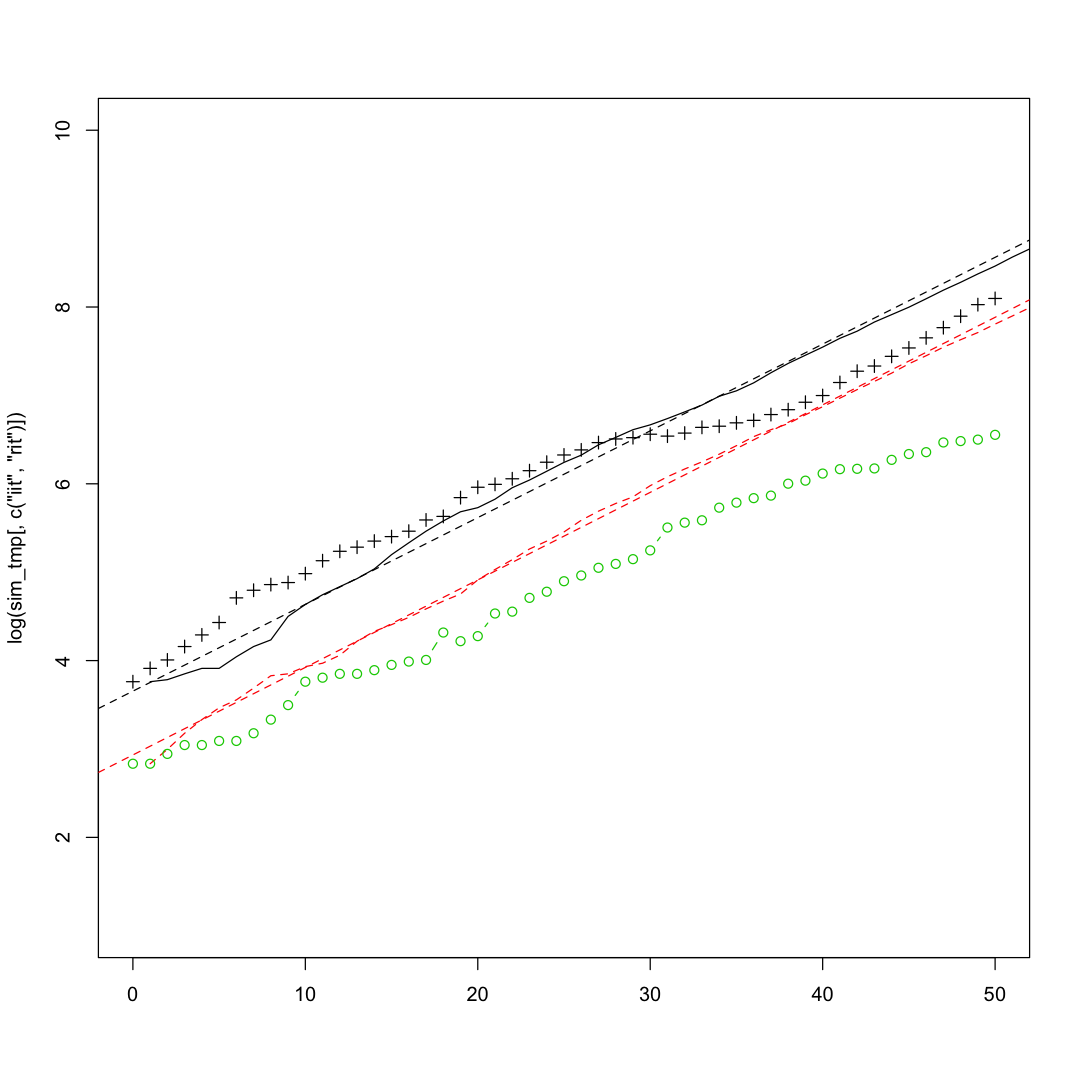

In [561]:
hoge <- 1:50
matplot(log(sim_tmp[,c("iit","rit")]),type="l", xlim=c(0,50),ylim=c(1,10))
points(dd1-33, log(covid$i-covid$re), lty=2, pch=3)
points(dd1-33, log(covid$re+covid$d), type="b", pch=1, col=3)

fuga <- log(sim_tmp[1:50,"iit"])
mogu <- lm(fuga~hoge)
print(mogu)
abline(mogu,lty=2,col=1)
fuga <- log(sim_tmp[1:50,"rit"])
mogu <- lm(fuga~hoge)
print(mogu)
abline(mogu,lty=2,col=2)

mean((covid$re[40:nd]+covid$d[40:nd]) / (covid$i[40:nd]-covid$r[40:nd]))
exp(2.87681 - 3.49175)

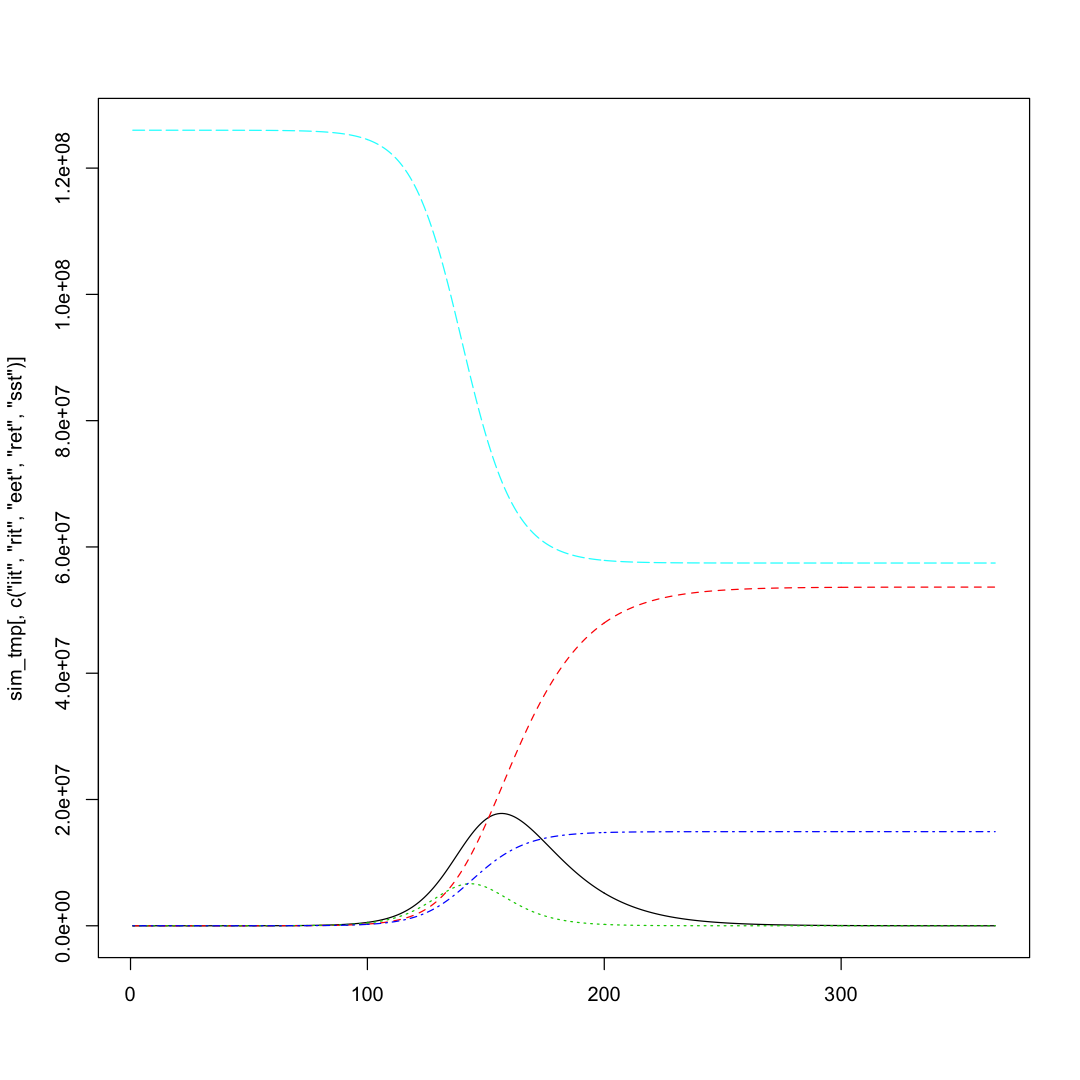

In [562]:
matplot(sim_tmp[,c("iit","rit","eet","ret","sst")], type="l")

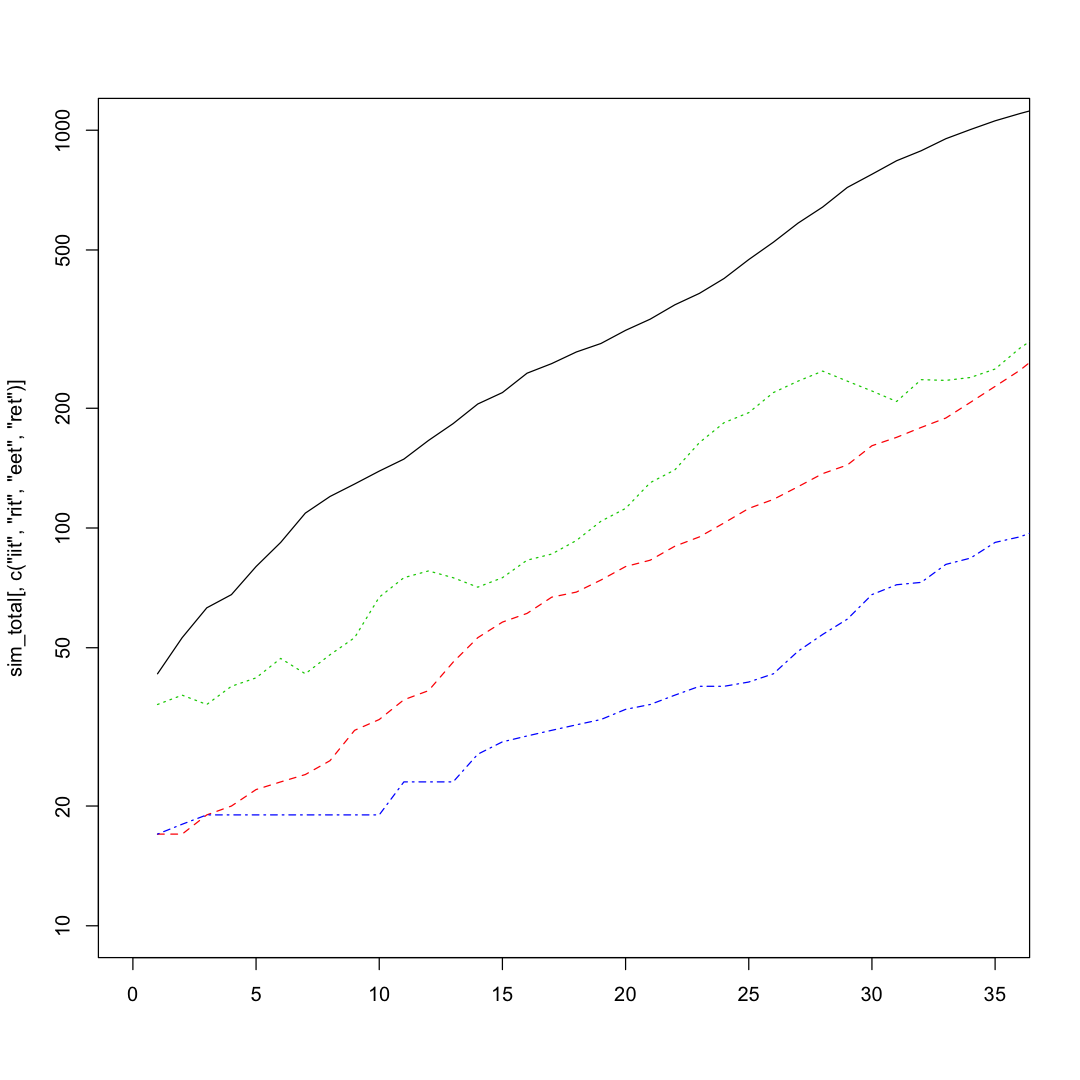

In [563]:
matplot(sim_total[,c("iit","rit","eet","ret")], type="l", xlim=c(0,35), log="y", ylim=c(10,1000))

We will optimize the model parameter alpha and gamma, using the number of infected and recovered of total Japan in the period between 2/17 to today.

The loss is defined by mean squared error of the number of infected and recovered population.

Note that `covid$i` is the counts of all infected and detected population including recovered, and in our model we do not distinguised recovred and dead. Therefore `iit` should be compared with `covid$i`-`covid$r`, while `rrt` should be compared with `covid$r`+`covid$d`


In [564]:
loss <- function(tmp){
    iii <- which(dd1 >= dd1[17] & dd1 <= dd1[nd])
    mean((log(covid$i[iii]) - log(tmp[1:length(iii),"iit"]))^2) + mean((log(covid$re[iii]) - log(tmp[1:length(iii),"rit"]))^2)
}
loss(sim.total)

[1] 0.5717385

Since the simulation is uses random variables and depends on initial growth drastically, we evaluated the loss using N=300 sample simulations with the same parameters.

In [565]:
lossn <- function(lpar, nl){
    alpha <- exp(lpar[["lalpha"]])
    beta  <- exp(lpar[["lbeta"]])
    gamma <- exp(lpar[["lgamma"]])

    par_tmp <- list(alpha=alpha, beta=beta, gamma=gamma, nn=n0_total, e0=e0_total, i0=i0_total, re0=r0_total, ri0=r0_total)
    lll <- sapply(1:nl,function(par){
        sim_tmp <- simSEIR(365, par=par_tmp)
        loss(sim_tmp)
    })
    return(mean(lll))
}

In [566]:
# sim_tmp <- simSEIR(365, par=par_tmp)
lossn(lpar=list(lalpha=log(alpha_tmp), lbeta=log(beta_tmp), lgamma=log(gamma_tmp)), nl=300)

[1] 0.816338

Now we can optimize alpha and gamma.

Beta is determined from alpha and gamma since we evaluated exponential growth of infected population.

Namely, when $E, I, R \ll N$, the growth will be $\lambda \simeq \alpha-\beta-\gamma$

In [567]:
tmp.sim <- optim(c(lalpha=log(alpha_tmp), lbeta=log(beta_tmp), lgamma=log(gamma_tmp)), function(lpar){lossn(lpar, 300)})

In [568]:
alpha_total <- exp(tmp.sim$par[[1]])
beta_total <- exp(tmp.sim$par[[2]])
gamma_total <- exp(tmp.sim$par[[3]])

c(alpha=alpha_total, beta=beta_total, gamma=gamma_total)
cat("average day to recover",(1/gamma_total)[[1]])

alpha      beta     gamma 
0.3198321 0.2210673 0.0185963

average day to recover 53.77414

(The estimated recovery rate seems rather small compared with stay in the hospitals...)

Now show the results of the simulation.

In [569]:
par_total <- list(alpha=alpha_total, beta=beta_total, gamma=gamma_total, nn=n0_total, e0=e0_total, i0=i0_total, re0=r0_total, ri0=r0_total)
sim_total <- simSEIR(365, par=par_total)

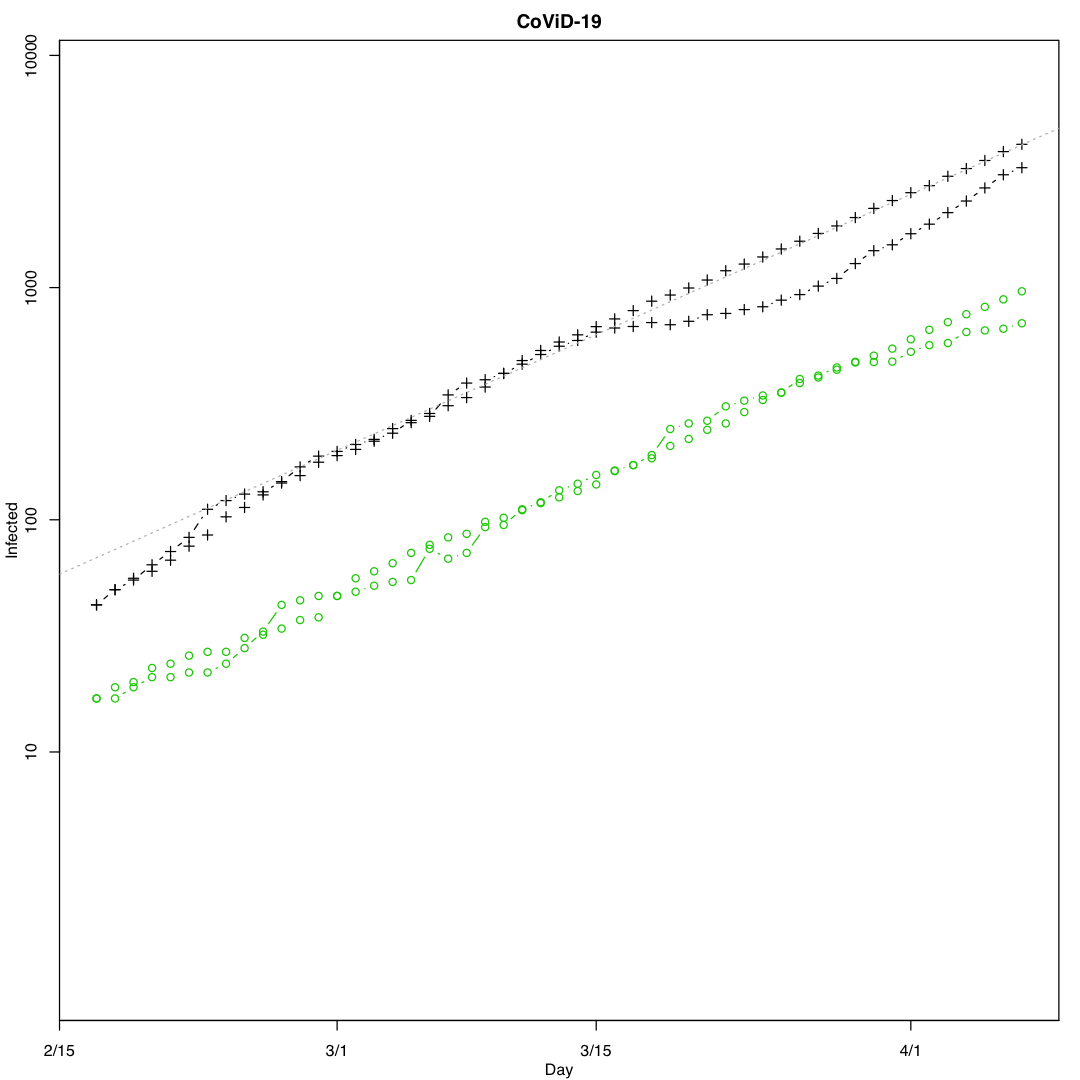

In [570]:
options(repr.plot.width=9, repr.plot.height=9)

plotFigure(function(){
    plot(dd1, log(covid$i-covid$re), axes=FALSE, frame=TRUE, type="b", lty=2, pch=3,
         xlim=c(dd1[17],dd1[nd]),ylim=c(0,9), xlab="Day", ylab="Infected", main="CoViD-19")
    points(dd1, log(covid$re+covid$d), type="b", pch=1, col=3)

    points(dd1[17]:dd1[nd], log(sim_total[1:(dd1[nd]-dd1[17]+1),"iit"]), pch=3, col=1)
    points(dd1[17]:dd1[nd], log(sim_total[1:(dd1[nd]-dd1[17]+1),"rit"]), pch=1, col=3)

#    points(dd1[17]:dd1[nd], log(sim_total[1:(dd1[nd]-dd1[17]+1),"eet"]), pch=4, col=2)
    
    axis(1,at=ddlabel-d0,labels=ticklabel)
    axis(2,at=log(c(10^(1:5))),labels=c(10^(1:5)))
    abline(model_exp_2, lty=3, col=8)
},rr=1.5,dir="fig",file=file_plot1,dev=c("x11"))


Show the prediction of entire Japan.

In [643]:
n0_tokyo <- 9.273e+6

par_tokyo <- list(alpha=alpha_total, beta=beta_total, gamma=gamma_total, nn=n0_tokyo, e0=e0_total%/%5, i0=i0_total%/%10, re0=r0_total%/%10, ri0=r0_total%/%10)
sim_tokyo <- simSEIR(365, par=par_tokyo)

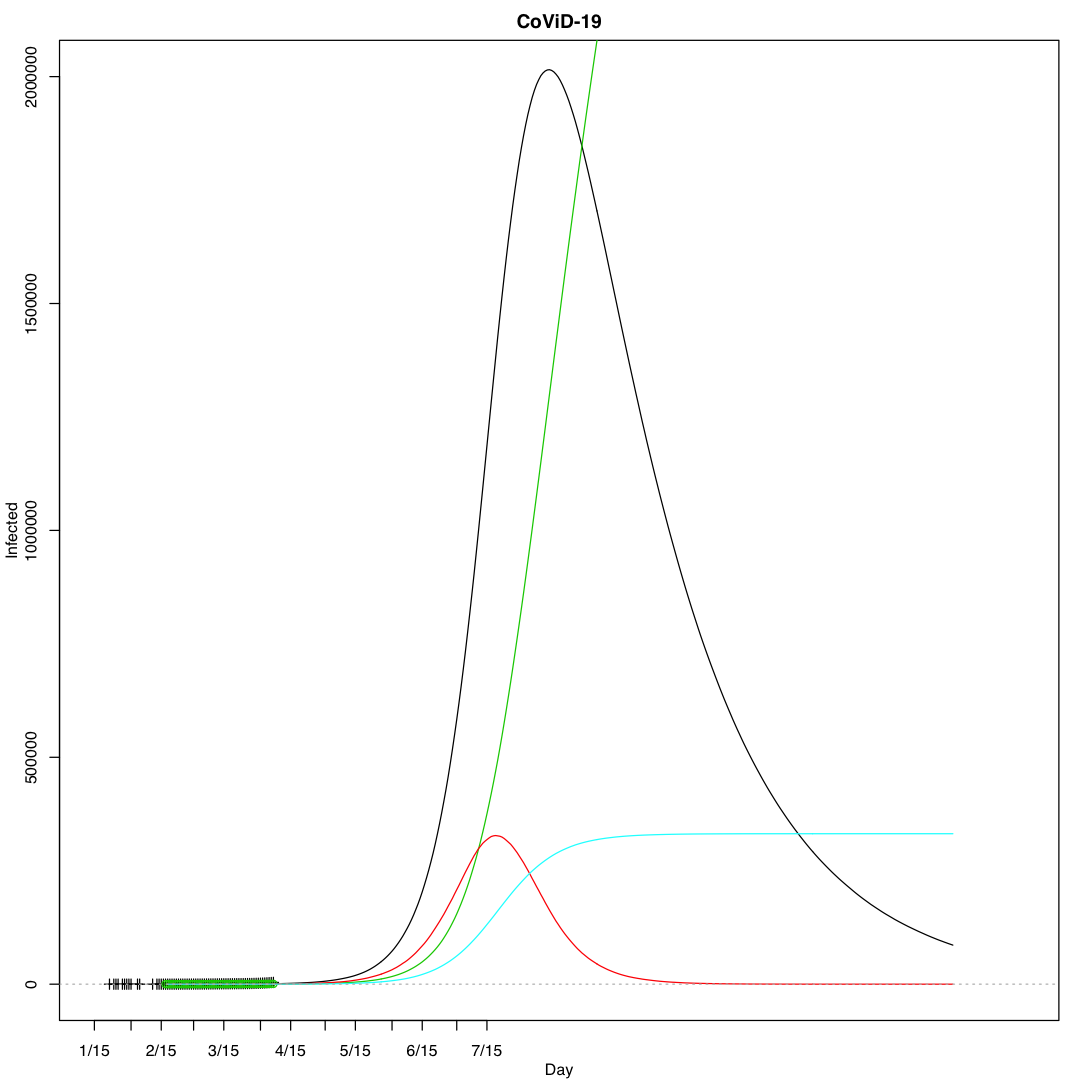

In [644]:
plotFigure(function(){
    plot(dd1, covid$i, axes=FALSE, frame=TRUE, type="b", lty=2, pch=3, xlim=c(1,430), ylim=c(0,2e+6),
         xlab="Day", ylab="Infected", main="CoViD-19")
    points(dd1, covid$re, pch=1, col=3)

    points(1:365+33,(sim_tokyo[,"iit"]), col=1,type="l")
    points(1:365+33,(sim_tokyo[,"rit"]), col=3,type="l")

    points(1:365+33,(sim_tokyo[,"eet"]), col=2,type="l")
    points(1:365+33,(sim_tokyo[,"ret"]), col=5,type="l")
    
    axis(1,at=ddlabel-d0,labels=ticklabel)
    axis(2)
    abline(model_exp_2, lty=3, col=8)
},rr=1.5,dir="fig",file=file_plot1,dev=c("x11"))

In [645]:
round(max(sim_tokyo[,"iit"]))
which.max(sim_tokyo[,"iit"])+d0+33


[1] 2015250

[1] 13Aug2020

The peak will be the late July, and the population of infected in Tokyo will reach 2 million, if the gov. fail.

Note: this model attributed the slower growth of infected population in Japan to the high rate of detection and isolation, which should be verified more carefully.

In [684]:
# alpha
# 0.366736905989128
# beta
# 0.277270163138632
# gamma
# 0.0187658947978138

rrr <- rbind(c(1.00, 1.00),
             c(0.95, 1.00),
             c(1.00, 1.05),
             c(0.95, 1.05),
             c(0.90, 1.00),
             c(1.00, 1.10),
             c(0.90, 1.10))

hoge <- NULL
for(aa in 1:nrow(rrr)){
    ra <- rrr[aa,1]
    rb <- rrr[aa,2]
    par_tmp <- list(alpha=alpha_total*ra, beta=beta_total*rb, gamma=gamma_total, nn=n0_tokyo, e0=e0_total%/%5, i0=i0_total%/%10, re0=r0_total%/%10, ri0=r0_total%/%10)
    sim_tmp <- simSEIR(730, par=par_tmp)
    hoge <- rbind(hoge, c(alpha=ra, beta=rb, max=max(sim_tmp[,"iit"]), peak=which.max(sim_tmp[,"iit"]), tot=sim_tmp[730,"rit"]+sim_tmp[730,"ret"]))
}
hoge

alpha,beta,max,peak,tot.rit
1.00,1.00,2009146,181,4262804
0.95,1.00,1570448,218,3652676
1.00,1.05,1664528,215,3739483
0.95,1.05,1197466,312,3056931
0.90,1.00,1085179,322,2928072
1.00,1.10,1307624,241,3176795
0.90,1.10,419970,582,1510709
